In [2]:
import torch
from torchtext import data
from torchtext import datasets
from collections import OrderedDict
from dataset import data_loaders, get_vocab
from utils import binary_accuracy
from nltk.corpus import wordnet as wn
import nltk
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
import spacy
from model import RNN
import itertools
import random
import warnings
import string
import gensim.downloader as api
import collections
import numpy as np
import math


In [3]:
stop_words = stopwords.words('english')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nlp = spacy.load('en')

In [39]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [40]:
MAX_VOCAB_SIZE = 25_000
TEXT.build_vocab(train_data, 
                max_size = MAX_VOCAB_SIZE, 
                vectors = "glove.6B.100d", 
                unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [4]:
import json
# with open('vocab.json', 'w') as fp:
#     json.dump(TEXT.vocab.stoi, fp)

vocab = json.load(open('vocab.json'))
# vocab = TEXT.vocab.stoi

In [4]:
a, b, test_iter = data_loaders(1, device=device, embedding=False)
TEXT = get_vocab()
vocab = TEXT.vocab.stoi
# a, b, test_iter = data_loaders(1, device, False)
# train_iter, test_iter = data.BucketIterator.splits(
#         (train_data, test_data),
#         batch_size = 1,
#         device = device)

In [5]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 32
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
N_EPOCHS = 5
BATCH_SIZE = 1
INPUT_DIM = len(vocab)
PAD_IDX = vocab['<pad>']

In [6]:
model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT
            )
path='tut2-model.pt'
model.load_state_dict(torch.load(path))
model = model.to(device)
model.eval()

RNN(
  (embedding): Embedding(25002, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)

In [7]:
reverse_vocab = {}
for k,v in vocab.items():
    reverse_vocab[v] = k

In [8]:
def get_ranking(ip, model):
    ranking = OrderedDict()
    ip_text = []
    for index, word in enumerate(ip.cpu()[0]):
        replace_index = torch.ones(len(ip[0]), dtype=torch.bool)
        word = reverse_vocab[word.item()]
        ip_text.append(word)
        if word not in string.punctuation and word not in stop_words and word != '<br />':
            replace_index[index] = False
            new_ip = ip[0][replace_index]
            new_ip = new_ip.view(1,len(new_ip))
            new_op = model(new_ip, torch.tensor([len(new_ip[0])], device=device)).squeeze()
            ranking[word] = torch.abs(ori_op - new_op).item()
    # import pdb; pdb.set_trace()
    pos = {}
    for text in nlp(" ".join(ip_text)):
        pos[text.text] = str(text.pos_)
    ranking_with_pos= {}
    for word, rank in ranking.items():
        ranking_with_pos[word] = {"value": rank, "pos": pos.get(word, "")}
    return(sorted(ranking_with_pos.items(), key=lambda x: x[1]['value'], reverse=True), " ".join(ip_text))


In [52]:
def replace_with_synonyms(alpha, model, ranking, embed_model, orig_text, orig_label):

    # import pdb; pdb.set_trace()
    # orig_text = " ".join(ip_text)
    # nlp(orig_text)
    synlist = {}
    mod_text = orig_text
    # for j in range(math.trunc(len(ranking)*alpha)):
    #     synlist[ranking[j][0]] = get_synonyms(ranking[j])
    key_list = [ranking[i][0] for i in  range(math.trunc(len(ranking)*alpha))]
    syn_list = [get_synonyms(ranking[i]) for i in  range(math.trunc(len(ranking)*alpha))]

#     permute_list = list(itertools.product(*syn_list))
#     for word_set in permute_list:
#         for key, word in zip(key_list, word_set):
#             mod_text = orig_text.replace(key, word)
#     import pdb;pdb.set_trace()
    if not [len(x) for x in syn_list]:
        return orig_text
    
    for i in range(max([len(x) for x in syn_list])):
        mod_text = orig_text
        for index, word in enumerate(key_list):
            if len(syn_list[index])-1 < i:
                mod_text = mod_text.replace(word, syn_list[index][-1])
            else:
                mod_text = mod_text.replace(word, syn_list[index][i])
#         print(mod_text)
#         if not mod_text:
#             # print("Is this the problem")
#             return orig_text

    # for index in range(math.trunc(len(ranking)*alpha)):
    #     print(ranking[index][0], synlist[ranking[index][0]])
    #     mod_text = orig_text.replace(ranking[index][0], synlist[ranking[index][0]][0])
    # print(mod_text)

        if embedding_constraint(orig_text, mod_text, embed_model, 0.65):
#             print("embedding satisfied")
            pred = predict(model, mod_text)
            if not bool(round(pred)) == bool(orig_label.cpu()[0]):
#                 print("orifinal text", orig_text)
#                 print("modified text", mod_text)
#                 with open('generated_data.txt', 'a+') as fp, open('original.txt', 'a+') as fo:
#                     fp.write(mod_text + '\n')
#                     fo.write(orig_text + '\n')

                return mod_text

        # if embedding_constraint(orig_text, mod_text, embed_model, 0.85):
        #     print("Acceptable",pred)
    # print("is it finally here")
    return orig_text
    # for i in 
    #     if len(synlist)-1 < :
    #         index = len(synlist)-1
    #     else:
    #         index=i
    #     orig_text = orig_text.replace(ranking[j][0],synlist[0])
    # print(predict(model, orig_text))

In [10]:
glove_preTrained=api.load("glove-wiki-gigaword-50")

def get_gloveWord(word):
    if word[0] in glove_preTrained.wv.vocab:
        syn = glove_preTrained.most_similar(word[0])
        syn = [item[0] for item in syn]
    else:
        syn = [word[0]]
    return syn 

In [11]:
def get_synonyms(word):

    # import pdb; pdb.set_trace()
    if word[1]['pos'] == 'VERB':
        pos = wn.VERB
    elif word[1]['pos'] == 'ADJ':
        pos = wn.ADJ
    elif word[1]['pos'] == 'ADV':
        pos = wn.ADV
    elif word[1]['pos'] == 'NOUN':
        pos = wn.NOUN
    else:
        return [word[0]]
    
    synonyms = []
    for syn in wn.synsets(word[0], pos=pos): 
        for l in syn.lemmas():
            synonyms.append(l.name().replace("_", " "))
    if not synonyms:
        synonyms.append(word[0])
    return list(set(synonyms)) 

In [12]:
def predict(model, sentence):
    tokenized = [tok.text for tok in nlp(sentence)] 
    # print(tokenized) #tokenize the sentence 
    indexed = [vocab.get(t, 0) for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return prediction.item()

In [13]:
def embedding_constraint(original_txt, mod_txt, embed_model, threshold):

    def cosine(u, v):
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

    for sent1, sent2 in zip(nltk.sent_tokenize(original_txt), nltk.sent_tokenize(mod_txt)):
        t1 = embed_model.encode(sent1)
        t2 = embed_model.encode(sent2)
        if(cosine(t1, t2) < threshold):
            return False
    return True

In [14]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [27]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.flush()

In [53]:


total =100
for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
    i=0
    epoch_acc = 0
    mod_epoch_acc = 0
    for batch in test_iter:
        if (i<total):
            ip, ip_len = batch.text
            label = batch.label
            ori_op = model(ip, ip_len).squeeze()
            acc = binary_accuracy(ori_op, label)
            epoch_acc += acc.item()
            # print(ori_op.item())

            ranking, ip_text = get_ranking(ip, model)
            # print(ip_text)

            modified_text = replace_with_synonyms(alpha, model, ranking, sbert_model, ip_text, label)

            # import pdb; pdb.set_trace()

            mod_op = predict(model, modified_text)
            mod_acc = binary_accuracy(torch.tensor(mod_op, device=device), label)
            mod_epoch_acc += mod_acc.item()
        i=i+1
    print("alpha is :", alpha)
    print("Test accuracy " , epoch_acc / total)
    writer.add_scalar('Accuracy/test', epoch_acc / total, alpha)
    writer.add_scalar('Accuracy/test after attack', mod_epoch_acc / total, alpha)
    print("Test accuracy after attack using wordnet" , mod_epoch_acc / total)
    # break

alpha is : 0.1
Test accuracy  0.84
Test accuracy after attack using wordnet 0.65
alpha is : 0.3
Test accuracy  0.84
Test accuracy after attack using wordnet 0.43
alpha is : 0.5
Test accuracy  0.84
Test accuracy after attack using wordnet 0.43
alpha is : 0.7
Test accuracy  0.84
Test accuracy after attack using wordnet 0.38
alpha is : 0.9
Test accuracy  0.84
Test accuracy after attack using wordnet 0.32


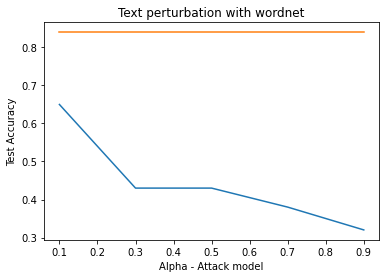

In [56]:
import matplotlib.pyplot as plt
plt.plot([0.1,0.3,0.5,0.7,0.9], [0.65, 0.43, 0.43, 0.38, 0.32])
plt.plot([0.1,0.3,0.5,0.7,0.9], [0.84, 0.84, 0.84, 0.84, 0.84])
plt.xlabel("Alpha - Attack model")
plt.ylabel("Test Accuracy")
plt.title("Text perturbation with wordnet")
plt.show()

In [61]:
i=0
for batch in test_iter:
    if (i>400) and (i<2000):
        ip, ip_len = batch.text
        label = batch.label
        ori_op = model(ip, ip_len).squeeze()
        # print(oi_op.item())

        ranking, ip_text = get_ranking(ip, model)
        # print(ip_text)

        modified_text = replace_with_synonyms(0.5, model, ranking, sbert_model, ip_text, label)
    i=i+1
    # print(modified_text)

/home/rbl/miniconda3/envs/ner/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


orifinal text The <unk> state that a comment must contain a minimum of four lines . That is the only reason I am saying anything more about <unk> . Because after all , my one line summary really says everything there is to say . There is absolutely NOTHING remotely entertaining in this film .
modified text The <unk> state that a asked able contain a minimum of four lines . That is the only reason I am noting anything more about <unk> . Because after all , my one line summary really says sure there is to say . There is something NOTHING positioning wonderfully in this movies .
orifinal text This movie is a pure disaster , the story is stupid and the editing is the worst I have seen , it <unk> you incredibly . The fish is badly made and some of its underwater shots are repeated a thousand times in the film . A truly , truly bad film .
modified text This movie is a pure flood , the story is wrong and the graphics is the flood I have seen , it <unk> you incredibly . The fish is troublely m

In [54]:
text = """I only went to see this movie because I have always liked Kevin Costner. I felt that Ashton did a great job in the Butterfly Effect. Unfortunately, even though these two actors were/are capable of good if not great acting moments some of that was missing here. Some of the scenes were just not believable and didn't have enough story line support.<br /><br />Though the movie claims influence from the hurricane Katrina aftermath, there was very little (none) to that effect in the movie.<br /><br />Overall, I liked the fact that the movie brought forward some of what goes into saving lives from a water perspective.<br /><br />The special effects were pretty good and more than a little intimidating. Not sure I'll ever go deep sea fishing again...<br /><br />I expected a little more emotion in the film than what was presented.<br /><br />Definitely a movie that could've been seen on DVD."""

In [55]:
predict(model, text)

0.06186283379793167

In [56]:
# with torch.no_grad():
ori_op = predict(model, text)
ranking = {}
original_text = text.replace('<br />', '')
for word in nlp(text):
    if word.text not in string.punctuation and word.text not in stop_words:
        new_text = original_text.replace(word.text, '')
        new_op = predict(model, new_text)
        ranking[word.text] = {"value": np.abs(ori_op - new_op).item(), "pos": word.pos_}

ranking = sorted(ranking.items(), key=lambda x: x[1]['value'], reverse=True)


In [72]:
alpha=0.3
orig_text = text
i=0
for j in range(math.trunc(len(ranking)*alpha)):
    synlist = get_synonyms(ranking[j])
    if len(synlist)-1 < i:
        index = len(synlist)-1
    else:
        index=i
    orig_text = orig_text.replace(ranking[j][0],synlist[index])
print(predict(model, orig_text))

0.7519028782844543


In [73]:
orig_text

"I only function to see to it this movie because I have always liked Kevin Costner. I finger that Ashton did a expectant job in the Butterfly Effect. Unfortunately, yet though these two doer were/are capable of good if not expectant acting bit some of that was missing here. Some of the scenes were just not credible and didn't have enough story line support.<br /><br />Though the movie claims influence from the hurricane Katrina aftermath, there was very little (none) to that effect in the movie.<br /><br />Overall, I liked the fact that the movie brought forward some of what goes into saving lives from a water perspective.<br /><br />The special effects were pretty good and more than a little intimidating. Not sure I'll ever go deep sea sportfishing again...<br /><br />I wait a little more emotion in the film than what was presented.<br /><br />Definitely a movie that could've been see to itn on videodisc."

In [61]:
predict(model, orig_text)

0.6764121651649475

In [33]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [32]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
# for sent in zip(text.split("."))
# t1 = sbert_model.encode(text)
# t2 = sbert_model.encode(orig_text)


In [109]:
# initializing list of list  
all_list = [[1, 3, 4], ['A', 'B', 'C'], ['xxx', 'yyy', 'zzz'] ] 
  
# printing lists  
print ("The original lists are : " + str(all_list)) 
  
# using itertools.product()   
# to compute all possible permutations 
res = list(itertools.product(*all_list)) 
  
# printing result 
print ("All possible permutations are : " +  str(res))

The original lists are : [[1, 3, 4], ['A', 'B', 'C'], ['xxx', 'yyy', 'zzz']]
All possible permutations are : [(1, 'A', 'xxx'), (1, 'A', 'yyy'), (1, 'A', 'zzz'), (1, 'B', 'xxx'), (1, 'B', 'yyy'), (1, 'B', 'zzz'), (1, 'C', 'xxx'), (1, 'C', 'yyy'), (1, 'C', 'zzz'), (3, 'A', 'xxx'), (3, 'A', 'yyy'), (3, 'A', 'zzz'), (3, 'B', 'xxx'), (3, 'B', 'yyy'), (3, 'B', 'zzz'), (3, 'C', 'xxx'), (3, 'C', 'yyy'), (3, 'C', 'zzz'), (4, 'A', 'xxx'), (4, 'A', 'yyy'), (4, 'A', 'zzz'), (4, 'B', 'xxx'), (4, 'B', 'yyy'), (4, 'B', 'zzz'), (4, 'C', 'xxx'), (4, 'C', 'yyy'), (4, 'C', 'zzz')]
